In [1]:
import optuna
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# datalarni yuklab olamiz

In [2]:
df = pd.read_csv('train.csv').drop(columns=['id'])
df_test = pd.read_csv('test.csv').drop(columns=['id'])
df

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,74.0,...,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0
1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,84.0,...,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0
2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,80.0,...,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0
3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,79.0,...,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0
4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,76.0,...,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,40.0,170.0,70.0,81.0,1.0,1.0,1.0,1.0,130.0,79.0,...,47.0,106.0,15.8,1.0,0.9,19.0,20.0,25.0,1.0,1.0
14996,40.0,155.0,50.0,75.0,1.0,1.2,1.0,1.0,100.0,60.0,...,51.0,106.0,14.1,1.0,0.8,22.0,17.0,20.0,0.0,0.0
14997,45.0,160.0,55.0,81.0,1.2,0.8,1.0,1.0,100.0,60.0,...,39.0,97.0,16.2,1.0,0.9,25.0,20.0,30.0,0.0,0.0
14998,50.0,160.0,60.0,80.0,0.7,1.0,1.0,1.0,120.0,80.0,...,88.0,151.0,14.5,1.0,0.9,19.0,13.0,11.0,0.0,0.0


# data ustida feature engineering qilingan 

In [3]:
def feature_engineering(df):
    # Bo'yni metrlarda
    df['Height_m'] = df['height(cm)'] / 100
    
    # Bo'yining kvadrati
    df['Height_squared'] = df['Height_m'] ** 2
    
    # Tananing massa indeksi (BMI)
    df['BMI'] = df['weight(kg)'] / df['Height_squared']
    
    # Belning bo'yiga nisbati
    df['Waist_to_height_ratio'] = df['waist(cm)'] / df['Height_m']
    
    # Chap va o'ng ko'z ko'rishidagi farq
    df['Eyesight_diff'] = df['eyesight(left)'] - df['eyesight(right)']
    
    # Chap va o'ng quloq eshitishidagi farq
    df['Hearing_diff'] = df['hearing(left)'] - df['hearing(right)']
    
    # Sistolik va diastolik bosimlar orasidagi farq
    df['Pulse_pressure'] = df['systolic'] - df['relaxation']
    
    # Qon bosimi yuqoriligi xavfi
    df['Hypertension_risk'] = ((df['systolic'] > 140) | (df['relaxation'] > 90)).astype(int)
    
    # Qondagi qand miqdori xavfi
    df['Blood_sugar_risk'] = (df['fasting blood sugar'] > 126).astype(int)
    
    # Yomon va yaxshi xolesterin nisbati
    df['LDL_to_HDL_ratio'] = df['LDL'] / df['HDL']
    
    # Xolesterin yuqoriligi xavfi
    df['Cholesterol_risk'] = (df['Cholesterol'] > 240).astype(int)
    
    # Gemoglobin miqdorining normallashtirilgan ko'rsatkichi
    df['Hemoglobin_normalized'] = df['hemoglobin'] / 15  # Erkaklar uchun umumiy
    
    # Buyrak funktsiyasi indeksi
    df['Kidney_function_index'] = df['serum creatinine'] / 1.2
    
    # Jigar funktsiyasi reytingi
    df['Liver_function_score'] = df['AST'] + df['ALT'] + df['Gtp']
    
    return df


In [4]:
df = feature_engineering(df)
df_test = feature_engineering(df_test)

# datamizni bolib olamiz

In [5]:
X = df.drop(columns=['smoking'])
y = df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# RandomizedSearchCV orqali 3 modelni eng yaxshi parametrlarni topib olamiz

In [6]:
param_dist_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(5, 11),
    'min_samples_split': np.arange(2, 8),
    'min_samples_leaf': np.arange(1, 6)
}

param_dist_lr = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'max_iter': np.arange(100, 301)
}

param_dist_rf = {
    'n_estimators': np.arange(100, 401, 50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(9, 16),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 6),
    'bootstrap': [True, False]
}

random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), param_distributions=param_dist_dt, n_iter=200, scoring='roc_auc', cv=5, random_state=1, return_train_score=True)
random_search_lr = RandomizedSearchCV(LogisticRegression(random_state=1), param_distributions=param_dist_lr, n_iter=70, scoring='roc_auc', cv=5, random_state=1, return_train_score=True)
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=1), param_distributions=param_dist_rf, n_iter=200, scoring='roc_auc', cv=5, random_state=1, return_train_score=True)

random_search_dt.fit(X_train, y_train)
random_search_lr.fit(X_train, y_train)
random_search_rf.fit(X_train, y_train)

print(random_search_dt.best_estimator_)
print(random_search_lr.best_estimator_)
print(random_search_rf.best_estimator_)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(5),
                       min_samples_leaf=np.int64(5),
                       min_samples_split=np.int64(7), random_state=1)
LogisticRegression(C=np.float64(10000.0), max_iter=np.int64(274),
                   random_state=1, solver='newton-cg')
RandomForestClassifier(criterion='log_loss', max_depth=np.int64(15),
                       min_samples_leaf=np.int64(1),
                       min_samples_split=np.int64(9),
                       n_estimators=np.int64(300), random_state=1)


# best parametrlar stacking orqali birlashtirib roc_auc_scoreni koramiz

In [7]:
best_dt = random_search_dt.best_estimator_
best_lr = random_search_lr.best_estimator_
best_rf = random_search_rf.best_estimator_

estimators = [('dt', best_dt), ('lr', best_lr), ('rf', best_rf)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacking_clf.fit(X_train, y_train)

y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: 0.8905063407908128


# bu yerda optuna orqali modelni eng yaxshi parametrlarni topamiz

In [8]:
# Optuna giperparametr optimallashtiruvchi funksiyalar

# Decision Tree
def objective_dt(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    dt = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=1
    )
    score = cross_val_score(dt, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Logistic Regression
def objective_lr(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs', 'newton-cg'])
    max_iter = trial.suggest_int('max_iter', 100, 300)
    
    lr = LogisticRegression(
        C=C, 
        solver=solver, 
        max_iter=max_iter, 
        random_state=1
    )
    score = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# Random Forest
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=1
    )
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study_dt = optuna.create_study(direction='maximize')
study_lr = optuna.create_study(direction='maximize')
study_rf = optuna.create_study(direction='maximize')

study_dt.optimize(objective_dt, n_trials=50)
study_lr.optimize(objective_lr, n_trials=50)
study_rf.optimize(objective_rf, n_trials=50)

print(study_dt.best_params)
print(study_lr.best_params)
print(study_rf.best_params)

[I 2024-10-28 19:56:58,500] A new study created in memory with name: no-name-6e3967ed-436a-427f-bfd3-692849ee9e8d
[I 2024-10-28 19:56:58,503] A new study created in memory with name: no-name-9c6680fa-ae9b-400e-bb15-2ccc6f9d059b
[I 2024-10-28 19:56:58,505] A new study created in memory with name: no-name-6063f27d-e4cc-4156-81b9-d72041fdf818
[I 2024-10-28 19:56:58,646] Trial 0 finished with value: 0.8406508982858234 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8406508982858234.
[I 2024-10-28 19:56:59,031] Trial 1 finished with value: 0.8442765214637884 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8442765214637884.
[I 2024-10-28 19:56:59,280] Trial 2 finished with value: 0.8499043696663552 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_sa

{'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3}
{'C': 1764.2220424236746, 'solver': 'newton-cg', 'max_iter': 182}
{'n_estimators': 338, 'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}


In [9]:

best_dt = DecisionTreeClassifier(**study_dt.best_params, random_state=1)
best_lr = LogisticRegression(**study_lr.best_params, random_state=1)
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=1)

estimators = [('dt', best_dt), ('lr', best_lr), ('rf', best_rf)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacking_clf.fit(X_train, y_train)

y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc}')


ROC AUC Score: 0.8911312905583811


# topilgan eng yaxshi parametrlar orqali pipeline orqali ozimiz model qilib olamiz

In [16]:
dt = DecisionTreeClassifier(random_state=1, max_depth=8, min_samples_leaf=3, min_samples_split=5, max_features='log2', criterion='entropy')
lr = LogisticRegression(random_state=1, C=np.float64(0.03359818286283781), max_iter=200, solver='newton-cg')
rf = RandomForestClassifier(random_state=1, criterion='entropy', max_depth=15, max_features='log2', 
                            min_samples_leaf=2, min_samples_split=7, n_estimators=400)

estimators = [
    ('dt', Pipeline([('scaler', StandardScaler()), ('dt', dt)])),
    ('lr', Pipeline([('scaler', StandardScaler()), ('lr', lr)])),
    ('rf', Pipeline([('scaler', StandardScaler()), ('rf', rf)]))
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator = RandomForestClassifier(random_state=1, criterion='entropy', max_depth=12, max_features='log2', 
                            min_samples_leaf=2, min_samples_split=7, n_estimators=400)
)

# Modelni o'rgatish
stacking_clf.fit(X_train, y_train)

y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc}')


ROC AUC Score: 0.8862172598529259


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
train_sizes, train_scores, val_scores = learning_curve(stacking_clf, X_train, y_train,
                                                      cv=skf, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10))

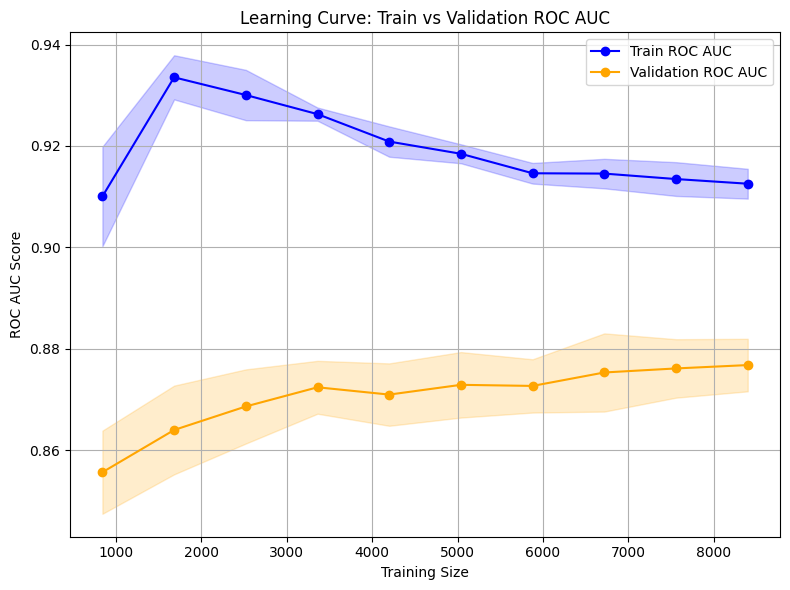

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, marker='o', label='Train ROC AUC', color='blue')
plt.plot(train_sizes, val_mean, marker='o', label='Validation ROC AUC', color='orange')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

plt.xlabel('Training Size')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve: Train vs Validation ROC AUC')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

plt.show()


In [21]:
y_pred_proba = stacking_clf.predict_proba(df_test)[:, 1]

In [22]:
sample = pd.read_csv('sample_submission.csv')
sample['smoking'] = y_pred_proba
# sample.to_csv('1-urinish.csv', index=False)